In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('raw data.csv', index_col=[0])

In [4]:
df = df[df['InvoiceDate'] <= '2011-12-01 23:59:59']

In [5]:
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']

In [6]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [7]:
invoice_count = df.groupby(['CustomerID'], as_index=False)['InvoiceNo'].count()

In [9]:
invoice_count.rename(columns={'InvoiceNo': 'frequency'}, inplace=True)

In [10]:
customer_total_revenue = df.groupby(['CustomerID'], as_index=False)['TotalRevenue'].sum()

In [11]:
customer_total_revenue.rename(columns={'TotalRevenue': 'monetary'}, inplace=True)

In [13]:
customer_total_revenue.monetary = round(customer_total_revenue.monetary, 2)

In [15]:
customer_total_revenue_invoice_count = customer_total_revenue.merge(invoice_count, on='CustomerID', sort=True)

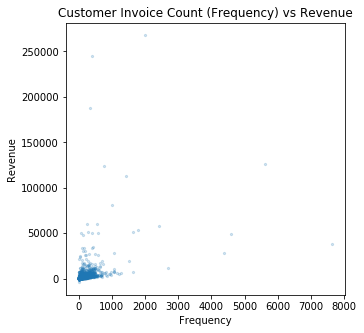

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(customer_total_revenue_invoice_count.frequency, customer_total_revenue_invoice_count.monetary, s=5, alpha=0.2)
plt.title('Customer Invoice Count (Frequency) vs Revenue')
plt.xlabel('Frequency')
plt.ylabel('Revenue')
plt.show()

In [22]:
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])

In [23]:
df['DaysSincePurchase'] = df['InvoiceDate'].max() - df['InvoiceDate']

In [24]:
customer_since_purchase = df.groupby(['CustomerID'], as_index=False)['DaysSincePurchase'].min()

In [32]:
RecentPurchase = customer_since_purchase['DaysSincePurchase']

In [33]:
RecentPurchaseDays = [None] * len(RecentPurchase)

In [34]:
for i in range(len(RecentPurchase)):
    RecentPurchaseDays[i] = RecentPurchase[i].days

In [39]:
customer_total_revenue_invoice_count_since_purchase['recency'] = RecentPurchaseDays

In [44]:
customer_total_revenue_invoice_count_since_purchase['monetary'] = customer_total_revenue_invoice_count_since_purchase['monetary'].apply(lambda x: 0.01 if x <= 0 else x)

In [52]:
customer_total_revenue_invoice_count_since_purchase['recency'] = customer_total_revenue_invoice_count_since_purchase['recency'].apply(lambda x: 0.01 if x <= 0 else x)

# Log Transformation

In [84]:
log_features = pd.DataFrame()
log_features['monetary'] = np.log(customer_total_revenue_invoice_count_since_purchase['monetary'])
log_features['frequency'] = np.log(customer_total_revenue_invoice_count_since_purchase['frequency'])
log_features['recency'] = np.log(customer_total_revenue_invoice_count_since_purchase['recency'])
log_features['customers'] = customer_total_revenue_invoice_count_since_purchase.CustomerID
log_features.head()

,monetary,frequency,recency,customers
0,-4.605170,0.693147,5.758902,12346.0
1,8.315121,5.141664,3.433987,12347.0
2,7.494007,3.433987,4.204693,12348.0
3,7.471676,4.290459,2.302585,12349.0
4,5.812338,2.833213,5.710427,12350.0


# Standard Scaler

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [64]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(log_features)

# KMeans

In [68]:
from sklearn.metrics.cluster import adjusted_rand_score, calinski_harabaz_score

In [182]:
k_means_scaled = KMeans(n_clusters=7)
k_means_scaled.fit(scaled_df)

cluster_preds_scaled = k_means_scaled.predict(scaled_df)

In [183]:
log_features_with_preds = log_features.copy()

In [184]:
log_features_with_preds['clusters'] = cluster_preds_scaled

In [185]:
log_features_with_preds.head()

,monetary,frequency,recency,customers,clusters
0,-4.605170,0.693147,5.758902,12346.0,2
1,8.315121,5.141664,3.433987,12347.0,6
2,7.494007,3.433987,4.204693,12348.0,1
3,7.471676,4.290459,2.302585,12349.0,6
4,5.812338,2.833213,5.710427,12350.0,5


In [186]:
clustered_df = customer_total_revenue_invoice_count_since_purchase.merge(log_features_with_preds[['clusters', 'customers']], left_on='CustomerID', right_on='customers', sort=True)

In [187]:
clustered_df.head()

,CustomerID,monetary,frequency,recency,clusters,customers
0,12346.0,0.01,2,317.0,2,12346.0
1,12347.0,4085.18,171,31.0,6,12347.0
2,12348.0,1797.24,31,67.0,1,12348.0
3,12349.0,1757.55,73,10.0,6,12349.0
4,12350.0,334.40,17,302.0,5,12350.0


In [188]:
clustered_df.drop(columns='customers', inplace=True)

In [189]:
clustered_df.groupby('clusters')['monetary'].sum()

clusters
0     382826.32
1     928097.12
2          0.54
3    1029298.87
4    2241699.66
5     166774.08
6    3265852.56
Name: monetary, dtype: float64

In [190]:
str(round((clustered_df.groupby('clusters')['monetary'].sum()[0] / clustered_df['monetary'].sum()) * 100, 2))

'4.78'

In [191]:
for i in range(clustered_df['clusters'].nunique()):
    print('cluster ' + str(i) + ' monetary sum - ' + str(round(clustered_df.groupby('clusters')['monetary'].sum()[i], 2)))
    print('cluster ' + str(i) + ' monetary mean - ' + str(round(clustered_df.groupby('clusters')['monetary'].mean()[i], 2)))
    print('cluster ' + str(i) + ' frequency mean - ' + str(round(clustered_df.groupby('clusters')['frequency'].mean()[i])))
    print('cluster ' + str(i) + ' recency mean - ' + str(round(clustered_df.groupby('clusters')['recency'].mean()[i])))
    print('cluster ' + str(i) + ' count - ' + str(round(clustered_df.groupby('clusters')['recency'].count()[i])))
    print('cluster ' + str(i) + ' monetary percentage - ' + str(round((clustered_df.groupby('clusters')['monetary'].sum()[i] / clustered_df['monetary'].sum()) * 100, 2)))
    print('cluster ' + str(i) + ' count percentage - ' + str(round(clustered_df.groupby('clusters')['recency'].count()[i] / len(clustered_df) * 100, 2)))
    print('')

cluster 0 monetary sum - 382826.32
cluster 0 monetary mean - 397.95
cluster 0 frequency mean - 21.0
cluster 0 recency mean - 139.0
cluster 0 count - 962
cluster 0 monetary percentage - 4.78
cluster 0 count percentage - 22.2

cluster 1 monetary sum - 928097.12
cluster 1 monetary mean - 906.34
cluster 1 frequency mean - 49.0
cluster 1 recency mean - 86.0
cluster 1 count - 1024
cluster 1 monetary percentage - 11.58
cluster 1 count percentage - 23.63

cluster 2 monetary sum - 0.54
cluster 2 monetary mean - 0.01
cluster 2 frequency mean - 11.0
cluster 2 recency mean - 226.0
cluster 2 count - 54
cluster 2 monetary percentage - 0.0
cluster 2 count percentage - 1.25

cluster 3 monetary sum - 1029298.87
cluster 3 monetary mean - 6908.05
cluster 3 frequency mean - 310.0
cluster 3 recency mean - 0.0
cluster 3 count - 149
cluster 3 monetary percentage - 12.84
cluster 3 count percentage - 3.44

cluster 4 monetary sum - 2241699.66
cluster 4 monetary mean - 2410.43
cluster 4 frequency mean - 137.0
cl

In [159]:
round(clustered_df.groupby('clusters')['recency'].count()[0] / len(clustered_df) * 100, 2)


31.86

In [151]:
clustered_df.count()

CustomerID    4334
monetary      4334
frequency     4334
recency       4334
clusters      4334
dtype: int64

In [153]:
clustered_df['recency'].count()

4334

# Unscaled

In [220]:
k_means = KMeans(init='random', n_clusters=5, n_init=300, max_iter = 1000, n_jobs = -1)
k_means.fit(log_features)

cluster_preds = k_means.predict(log_features)

In [221]:
log_features_non_scaled_with_preds = log_features.copy()

In [222]:
log_features_non_scaled_with_preds['clusters'] = cluster_preds

In [223]:
clustered_df_non_scaled = customer_total_revenue_invoice_count_since_purchase.merge(log_features_non_scaled_with_preds[['clusters', 'customers']], left_on='CustomerID', right_on='customers', sort=True)

In [224]:
clustered_df_non_scaled.drop(columns='customers', inplace=True)

In [225]:
for i in range(clustered_df_non_scaled['clusters'].nunique()):
    print('cluster ' + str(i) + ' monetary sum - ' + str(round(clustered_df_non_scaled.groupby('clusters')['monetary'].sum()[i], 2)))
    print('cluster ' + str(i) + ' monetary mean - ' + str(round(clustered_df_non_scaled.groupby('clusters')['monetary'].mean()[i], 2)))
    print('cluster ' + str(i) + ' frequency mean - ' + str(round(clustered_df_non_scaled.groupby('clusters')['frequency'].mean()[i])))
    print('cluster ' + str(i) + ' recency mean - ' + str(round(clustered_df_non_scaled.groupby('clusters')['recency'].mean()[i])))
    print('cluster ' + str(i) + ' count - ' + str(round(clustered_df_non_scaled.groupby('clusters')['recency'].count()[i])))
    print('cluster ' + str(i) + ' monetary percentage - ' + str(round((clustered_df_non_scaled.groupby('clusters')['monetary'].sum()[i] / clustered_df_non_scaled['monetary'].sum()) * 100, 2)))
    print('cluster ' + str(i) + ' count percentage - ' + str(round(clustered_df_non_scaled.groupby('clusters')['recency'].count()[i] / len(clustered_df_non_scaled) * 100, 2)))
    print('')

cluster 0 monetary sum - 1818451.51
cluster 0 monetary mean - 2038.62
cluster 0 frequency mean - 88.0
cluster 0 recency mean - 90.0
cluster 0 count - 892
cluster 0 monetary percentage - 22.69
cluster 0 count percentage - 20.58

cluster 1 monetary sum - 1430598.54
cluster 1 monetary mean - 1646.26
cluster 1 frequency mean - 90.0
cluster 1 recency mean - 92.0
cluster 1 count - 869
cluster 1 monetary percentage - 17.85
cluster 1 count percentage - 20.05

cluster 2 monetary sum - 1690384.21
cluster 2 monetary mean - 1998.09
cluster 2 frequency mean - 91.0
cluster 2 recency mean - 95.0
cluster 2 count - 846
cluster 2 monetary percentage - 21.09
cluster 2 count percentage - 19.52

cluster 3 monetary sum - 1808879.69
cluster 3 monetary mean - 2088.78
cluster 3 frequency mean - 99.0
cluster 3 recency mean - 87.0
cluster 3 count - 866
cluster 3 monetary percentage - 22.57
cluster 3 count percentage - 19.98

cluster 4 monetary sum - 1266235.2
cluster 4 monetary mean - 1470.66
cluster 4 frequency

In [ ]:
""